# -----------------------------------------------------------------------------------------
# 1. Setup
# -----------------------------------------------------------------------------------------

#### Import Packages

In [1]:
# For reading in Json file
import json

# general packages
import pandas as pd
import numpy as np
import time

# For selecting period of valuation table
from dateutil.relativedelta import relativedelta

#### Import Functions

In [2]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 1

# Import functions for scraping the data
%aimport get_data
import get_data as gd

# Import functions for analysing the data
%aimport analyse_portfolio
import analyse_portfolio as ap

#### Configure Notebook

In [3]:
# Update the default number of rows that are displayed
pd.set_option('display.max_rows', 500)

# -----------------------------------------------------------------------------------------
# 2. Read in Transactions Data
# -----------------------------------------------------------------------------------------

#### Scrape Data to Populate Files

In [4]:
gd.create_company_ticker_to_name_map()
gd.create_exchange_ticker_to_name_map()

#### Read in Manually Populated Transactions Table

In [5]:
raw_transactions = gd.read_in_raw_transactions_data()

#### Use Scraped Data to Add Columns to Transactions Data

In [6]:
# Add company name
transactions_comp_name = gd.create_company_name_col_using_ticker(raw_transactions)

The following stocks did not have an associated company name:
|     | stock_ticker   | exchange_ticker   |
|----:|:---------------|:------------------|
|  45 | SVE            | TSV               |
|  49 | NOVR           | TSV               |
|  52 | MMG            | TSV               |
|  53 | RSLV           | TSV               |
|  59 | LGD            | TOR               |
|  61 | SSV            | TSV               |
| 101 | ELEC           | TSV               |
| 107 | GLO            | TOR               |


In [7]:
# Add Exchange name
transactions_exch_name = gd.create_exchange_name_nd_curency_cols_using_ticker(transactions_comp_name)

In [10]:
# Add aggregate price columns that track fees, stock prices, bep over time, among others
transactions = gd.add_aggregate_price_columns(transactions_exch_name)

# -----------------------------------------------------------------------------------------
# 3. Create Stock Valuation Table
# -----------------------------------------------------------------------------------------

#### Scrape Historic Stock Prices & Dividends Recieved For Each Stock

In [11]:
unique_tickers_list = list(transactions["stock_ticker"].drop_duplicates())
ticker_start_date_list = [str(min(transactions[transactions["stock_ticker"] == ticker]["date"]))[:10] for ticker in unique_tickers_list]
gd.create_table_of_historic_stock_prices(unique_tickers_list, ticker_start_date_list)

- ELEC: No data found for this date range, symbol may be delisted
ELEC not found
- LGD: No data found for this date range, symbol may be delisted
LGD not found
- MMG: No data found for this date range, symbol may be delisted
MMG not found
- NOVR: No data found, symbol may be delisted
NOVR not found
- RSLV: No data found, symbol may be delisted
RSLV not found
- SSV: No data found for this date range, symbol may be delisted
SSV not found
- SVE: No data found for this date range, symbol may be delisted
SVE not found


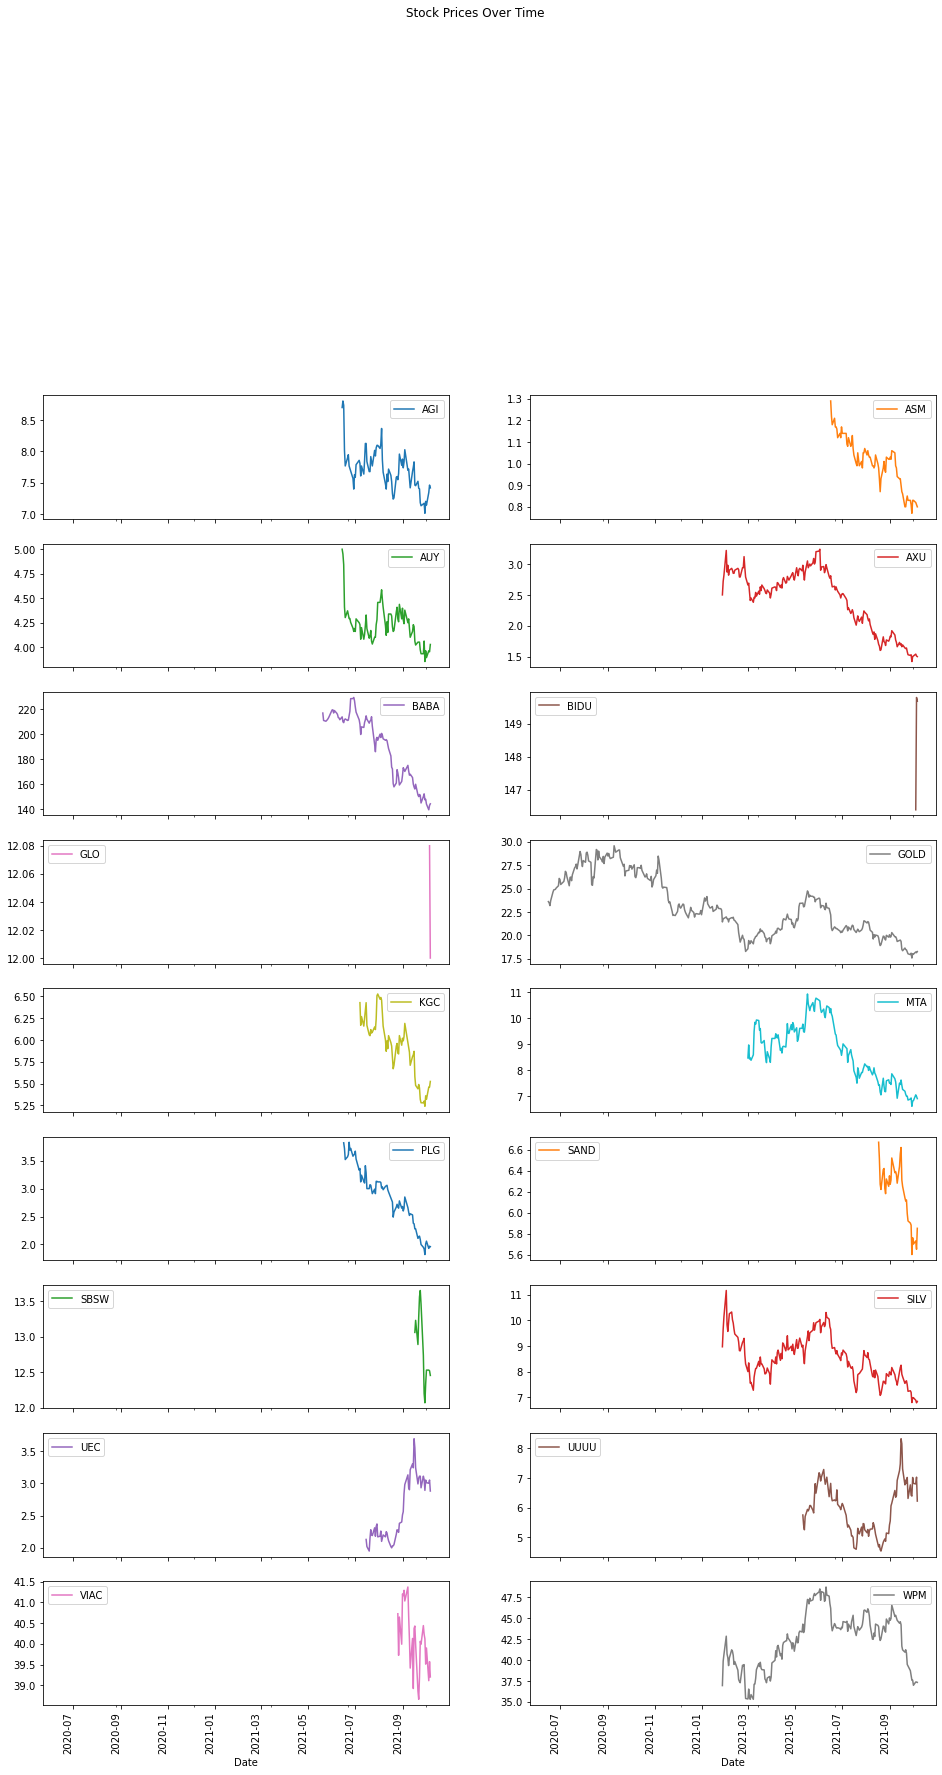

In [45]:
ap.plot_stock_prices()

#### Scrape Historic Exchange Rates

In [12]:
base_currency = 'EUR'

In [13]:
unique_currency_list = list(transactions["currency"].drop_duplicates())
start_date = min(transactions["date"]).date()
gd.create_exchange_rate_to_date_map(base_currency, unique_currency_list, start_date)

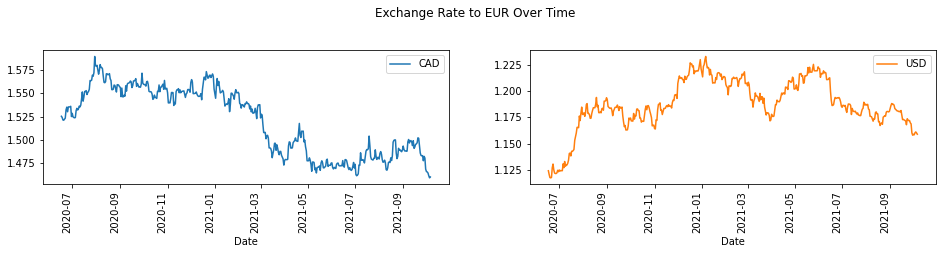

In [43]:
ap.plot_exchange_rates(base_currency)

#### Calculate Daily Account Cash Balance

In [14]:
# get the cumulative amount paid into the account broken down by day
daily_amount_in_account_to_date_df = gd.calculate_amount_in_cumulative_account_each_day()

In [15]:
# get the cumulative amount spend on stocks broken down by day
daily_amount_spent_to_date_df = gd.calculate_cumulative_amount_spent_each_day(transactions)

In [16]:
# get the daily cash balance
daily_cash_balance = daily_amount_in_account_to_date_df.sub(daily_amount_spent_to_date_df, fill_value=0)

In [17]:
# Merge these into one table
daily_balance_summary_table = pd.concat([daily_amount_in_account_to_date_df, daily_amount_spent_to_date_df, daily_cash_balance], axis=1).set_axis(["in_account", "spent", "balance"], axis=1)

In [46]:
stock_data = gd.get_specific_stock(transactions, "GOLD", "NSY")

In [48]:
stock_data.dtypes

date                             object
stock_ticker                     object
exchange_ticker                  object
num_shares                        int64
share_price                     float64
exchange_rate                   float64
company_name                     object
currency                         object
exchange_name                    object
share_cost_in_local_currency    float64
currency_exchange_fee           float64
fixed_transaction_fee           float64
variable_transaction_fee        float64
total_outgoing_in_eur           float64
share_cost_in_eur               float64
total_shares_to_date              int64
break_even_price                float64
dtype: object

In [96]:
# {"day": relativedelta(days=1),
#  "week": relativedelta(weeks=1),
#  "month": relativedelta(months=1),
#  "quarter": relativedelta(months=3),
#  "year": relativedelta(years=1),
# }

base_currency = "EUR"
val_table = ap.create_valuation_table(stock_data, relativedelta(days=1), base_currency)